In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from loader import load_data
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [3]:
df = load_data(r"/Users/christian/supsi/6th sem/bayesian_retry/data_hockey")
df = df.loc[df.Resultat != " -:-"].reset_index(drop=True)
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Do,29.04.2021,20:00,ZSC Lions,Genève-Servette HC,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",50,"SRF,RTS,RSI,MYSPORTS",20211105000354,NL,CH,Playoff 1/2 Final
2446,Sa,01.05.2021,20:00,SC Rapperswil-Jona Lakers,EV Zug,3:6,0:3|2:1|1:2,NaN,Ende,False,"St.Galler Kantonalbank Arena, 8640 Rapperswil SG",50,"SRF,RTS,RSI,MYSPORTS",20211105000355,NL,CH,Playoff 1/2 Final
2447,Mo,03.05.2021,20:00,EV Zug,Genève-Servette HC,1:0,0:0|1:0|0:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",50,"SRF,RTS,RSI,MYSPORTS",20211105000359,NL,CH,Playoff Final
2448,Mi,05.05.2021,19:00,Genève-Servette HC,EV Zug,1:2,0:0|1:1|0:1,NaN,Ende,False,"Les Vernets, 1227 Les Acacias GE",50,"SRF,RTS,RSI,MYSPORTS",20211105000360,NL,CH,Playoff Final


# Preprocessing and data exploration

In [4]:
# Split the 'Resultat' column into 'home_goals' and 'away_goals'
df['home_goals'] = df['Resultat'].str.split(':').str[0].astype(int)
df['away_goals'] = df['Resultat'].str.split(':').str[1].astype(int)

# Filter scores for 'SC Bern' when they played at home
hcl_home_scores = df[df['Home'] == 'HC Lugano']['home_goals'].tolist()

# Filter scores for 'SC Bern' when they played away
hcl_away_scores = df[df['Away'] == 'HC Lugano']['away_goals'].tolist()

print(hcl_home_scores)  # [3, 2]
print(hcl_away_scores)  # [4]

[2, 1, 3, 3, 3, 1, 3, 1, 2, 4, 1, 1, 5, 3, 3, 4, 6, 5, 2, 2, 3, 4, 2, 5, 5, 4, 4, 2, 3, 2, 3, 1, 5, 4, 2, 2, 6, 4, 3, 6, 1, 4, 4, 3, 7, 3, 3, 3, 7, 7, 6, 0, 4, 3, 4, 5, 1, 1, 4, 5, 2, 2, 5, 3, 4, 2, 4, 3, 4, 4, 2, 2, 2, 5, 4, 8, 3, 6, 3, 3, 4, 4, 2, 1, 5, 3, 3, 4, 3, 2, 1, 1, 3, 3, 6, 2, 3, 5, 4, 2, 6, 3, 2, 2, 4, 3, 3, 8, 3, 3, 4, 7, 1, 4, 2, 3, 5, 6, 3, 5, 1, 5, 6, 0, 3, 4, 0, 3, 4, 6, 1, 6, 0, 5, 4, 5, 5, 6, 3, 5, 6, 3, 1, 3, 1, 2, 4, 3, 4, 8, 5, 4, 1, 4, 2, 2, 4, 1, 3, 6, 1, 2, 3, 1, 1, 5, 3, 3, 6, 0, 4, 2, 1, 2, 5, 5, 1, 0, 1, 4, 2, 4, 4, 5, 2, 1, 3, 5, 3, 1, 2, 1, 2, 4, 5, 4, 3, 2, 2, 7, 2, 4, 6, 1, 7, 6, 2, 3]
[7, 5, 2, 2, 4, 1, 1, 3, 5, 1, 1, 1, 8, 3, 2, 2, 0, 7, 4, 7, 4, 1, 4, 2, 4, 1, 2, 1, 3, 4, 1, 4, 1, 1, 3, 1, 0, 1, 2, 6, 1, 4, 4, 4, 2, 2, 3, 2, 2, 3, 2, 3, 4, 4, 2, 5, 5, 4, 3, 0, 1, 3, 2, 1, 3, 5, 2, 0, 2, 5, 0, 1, 1, 1, 3, 0, 1, 2, 2, 3, 0, 3, 5, 1, 5, 2, 3, 0, 2, 4, 1, 3, 4, 5, 1, 4, 4, 4, 1, 1, 4, 2, 4, 5, 4, 4, 1, 1, 1, 4, 0, 0, 6, 2, 2, 1, 3, 5, 3, 3, 6, 4, 4, 2, 3,

<AxesSubplot: xlabel='value', ylabel='Count'>

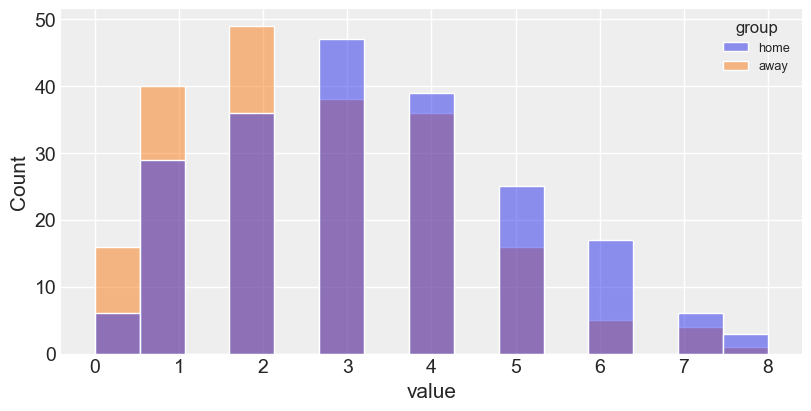

In [5]:
y  = pd.DataFrame(dict(value=np.r_[hcl_home_scores, hcl_away_scores], group=np.r_[['home']*len(hcl_home_scores), ['away']*len(hcl_away_scores)]))
sns.histplot(data=y, x="value", hue="group")

In [6]:
print(f"Sample mean goals at home: {np.mean(hcl_home_scores):.3f}")
print(f"Sample mean goals away: {np.mean(hcl_away_scores):.3f}")

Sample mean goals at home: 3.322
Sample mean goals away: 2.644


# Hypothesis test 1
We want to compare if HC Lugano scores more goals while playing at home or away.

# Research question
From the distributions we see that when the game is played at home the mean goals are higher.

We want to test if this is true:
* Are the expected goals for the home team higher than the ones away?

We assume the distribution is Normal.

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_{home}$, $\bar{y}_{away}$) 

    * sample standard deviations ($s_{home}, s_{away}$) 

    * numerosity ($n_{home}, n_{away}$)


* The sample are drawn from two populations with unknown parameters $\mu_{home}, \mu_{away}, \sigma_{home}, \sigma_{away}$.

# Background information to set the prior
From a research we found the mean goals per game is 5.51 (https://www.sport12x.com/en/mathematics/ice-hockey). Given this we can divide the score between the two teams, resulting in a mean of 2.75 goals per team in one game.

We assume goals scored follow Poisson distribution, then the variance is equal to the mean. This means the standard deviation of goals per team is $SD = \sqrt{mean} = \sqrt{\frac{5.51}{2}} \approx 1.66$

We know that:
$$
\frac{alpha}{beta} = mu
$$
$$
\frac{alpha}{beta^2} = sigma^2
$$

therefore we can calculate alpha and beta as:
$$
alpha = \frac{mu^2}{sigma^2}
$$
$$
beta = \frac{mu}{sigma^2}
$$

In [55]:
mu = 2.75
sigma = 1.37

alpha = mu**2 / sigma**2
beta = mu / sigma**2
alpha, beta

(4.029250359635569, 1.4651819489583886)

# Prior for $\mu_{\text{home}}$ and $\mu_{\text{away}}$

* The  mean goals of the population lies in (1.8, 5.4);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{home}}   \sim  Gam(4, 1.1)
$$
$$
\mu_{\text{away}}   \sim  Gam(4, 1.1)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



#  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).
$$
\mu_{\text{home}}\sim Gam(4,1.1) 
$$
$$
\vec{y}_{\text{home}} \sim Po(\mu_{\text{home}})
$$
$$
\mu_{\text{away}} \sim Gam(4,1.1)
$$
$$
\vec{y}_{\text{away}} \sim Po(\mu_{\text{away}})
$$

# Comparing the two means

In [56]:
with pm.Model() as model:
    #prior
    mu_home = pm.Gamma('mu_home', alpha, beta)
    mu_away = pm.Gamma('mu_away', alpha, beta)

    #likelihood of group 1
    y_home = pm.Poisson('y_1', mu=mu_home, observed= hcl_home_scores)

    #likelihood of group 2
    y_away = pm.Poisson('y_2', mu=mu_away, observed= hcl_away_scores)

    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic('diff_of_means', mu_home - mu_away)

In [57]:
with model:
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_away, mu_home]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot: title={'center': 'mu_home'}>,
        <AxesSubplot: title={'center': 'mu_home'}>],
       [<AxesSubplot: title={'center': 'mu_away'}>,
        <AxesSubplot: title={'center': 'mu_away'}>],
       [<AxesSubplot: title={'center': 'diff_of_means'}>,
        <AxesSubplot: title={'center': 'diff_of_means'}>]], dtype=object)

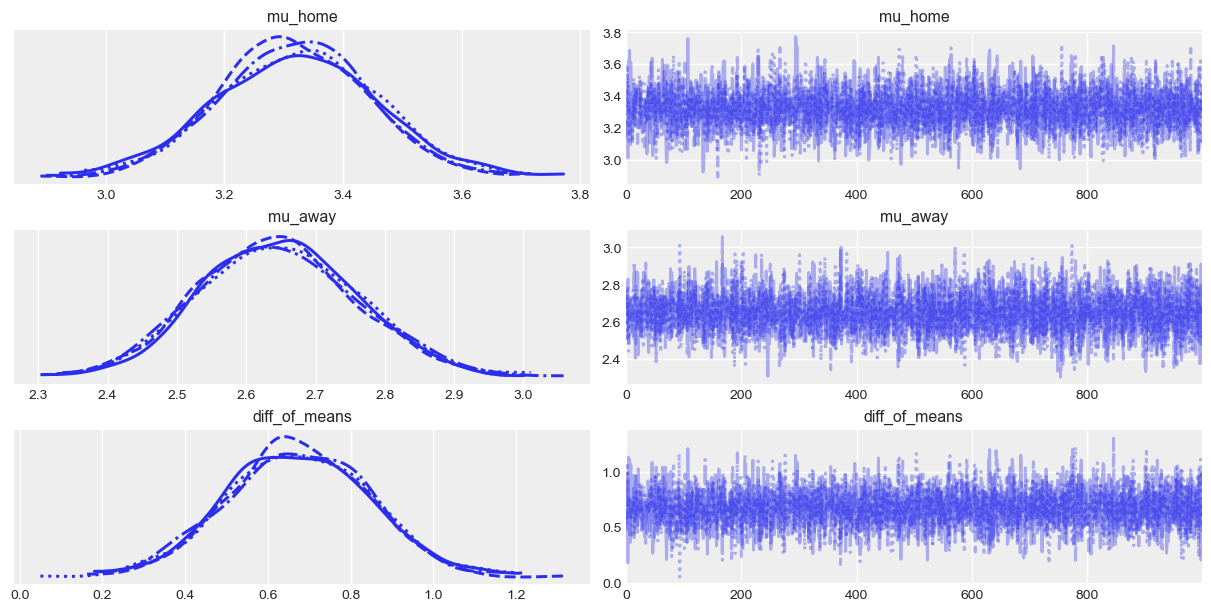

In [58]:
az.plot_trace(trace)

It converges well

In [59]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_home,3.321,0.129,3.055,3.562,0.002,0.002,3113.0,2528.0,1.0
mu_away,2.647,0.112,2.434,2.869,0.002,0.001,3493.0,2228.0,1.0
diff_of_means,0.674,0.171,0.334,0.997,0.003,0.002,3310.0,2659.0,1.0


<AxesSubplot: title={'center': 'diff_of_means'}>

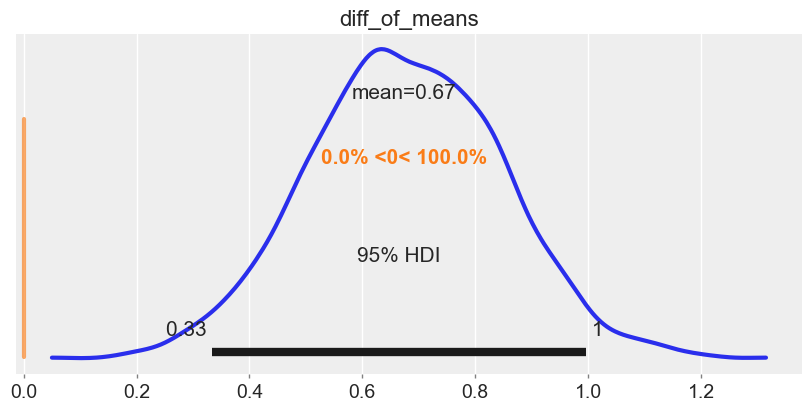

In [60]:
az.plot_posterior(trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95)

<AxesSubplot: title={'center': 'diff_of_means'}>

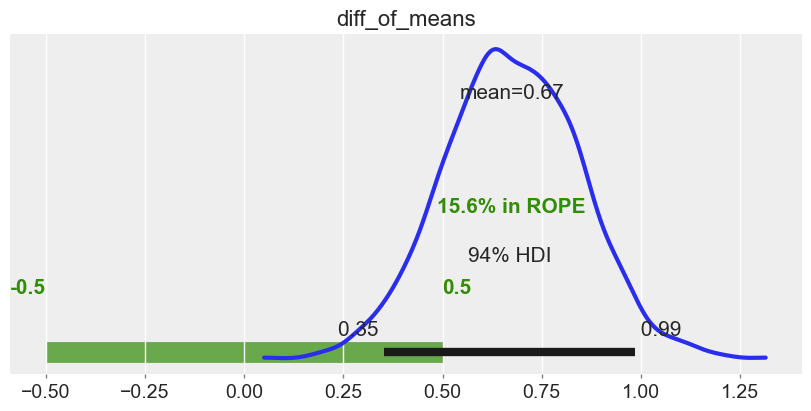

In [61]:
az.plot_posterior(trace,  var_names="diff_of_means", rope=[-0.5,0.5])

In [62]:
samples = az.extract_dataset(trace,)
diff_samples = samples.diff_of_means.values
p_significant_positive =  ((diff_samples > 0.5).sum()) / len(diff_samples)
p_significant_negative = ((diff_samples < -0.5).sum()) / len(diff_samples)
p_practically_eq = 1 -  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.844
p_practically_eq:  0.156
p_significant_negative:  0.000


/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_2624/2962428823.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  samples = az.extract_dataset(trace,)


# Posterior predictive checks

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([<AxesSubplot: xlabel='y_1 / y_1'>,
       <AxesSubplot: xlabel='y_2 / y_2'>], dtype=object)

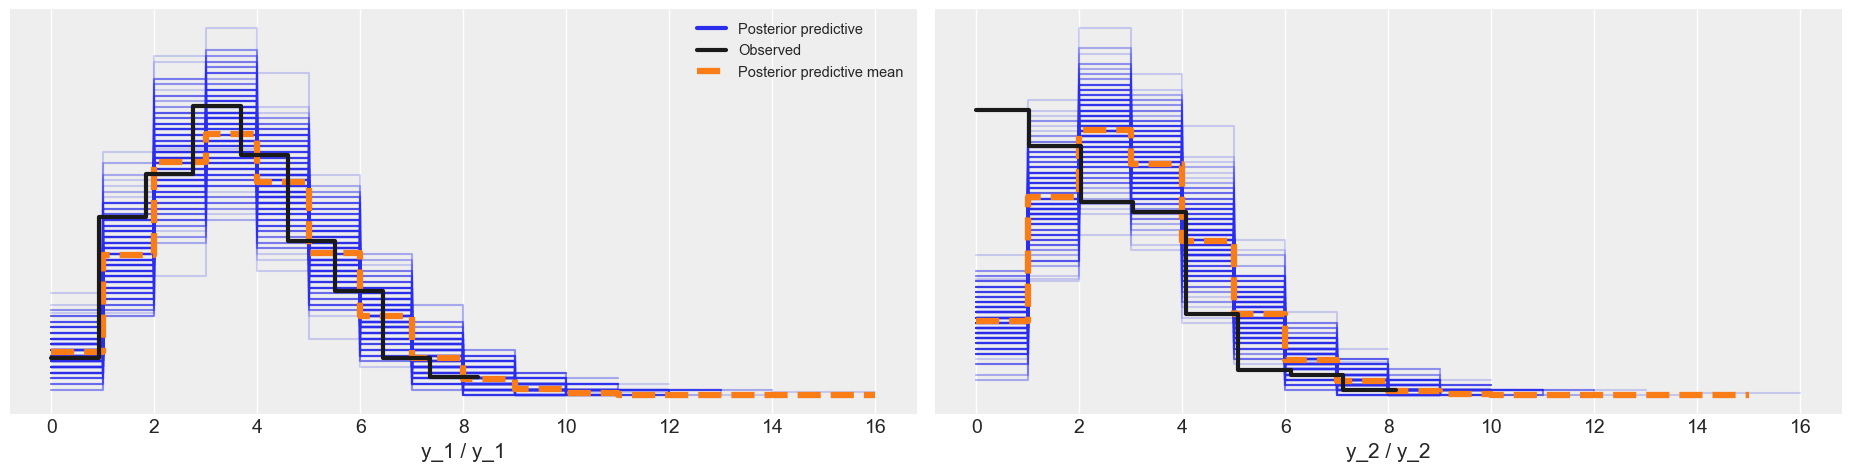

In [63]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with model:
     ppc = pm.sample_posterior_predictive(trace, samples=300)
    
# The density is too low in the bulk of the distribution, for both groups. 
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

## Prior sensitivity

In [64]:
mu_new = 3.6
# double the sima to have a more diffuse prior
sigma_new = sigma * 2

alpha_new = mu_new**2 / sigma_new**2
beta_new = mu_new / sigma_new**2

In [65]:
with pm.Model() as model_sensitivity:
    #prior
    mu_home_new = pm.Gamma('mu_home_new', alpha_new, beta_new)
    mu_away_new = pm.Gamma('mu_away_new', alpha_new, beta_new)

    #likelihood of group 1
    y_home_new = pm.Poisson('y_1', mu=mu_home_new, observed= hcl_home_scores)

    #likelihood of group 2
    y_away_new = pm.Poisson('y_2', mu=mu_away_new, observed= hcl_away_scores)

    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means_new = pm.Deterministic('diff_of_means_new', mu_home_new - mu_away_new)

In [66]:
with model_sensitivity:
    trace_sensitivity = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_away_new, mu_home_new]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [67]:
az.summary(trace_sensitivity, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_home_new,3.322,0.122,3.083,3.554,0.002,0.001,3682.0,2576.0,1.0
mu_away_new,2.645,0.115,2.419,2.870,0.002,0.001,3247.0,2610.0,1.0
diff_of_means_new,0.677,0.168,0.360,1.012,0.003,0.002,3409.0,2879.0,1.0


In both cases of the chosen priors, r_hat has a value of 1, meaning the model converges well.

<AxesSubplot: title={'center': 'diff_of_means_new'}>

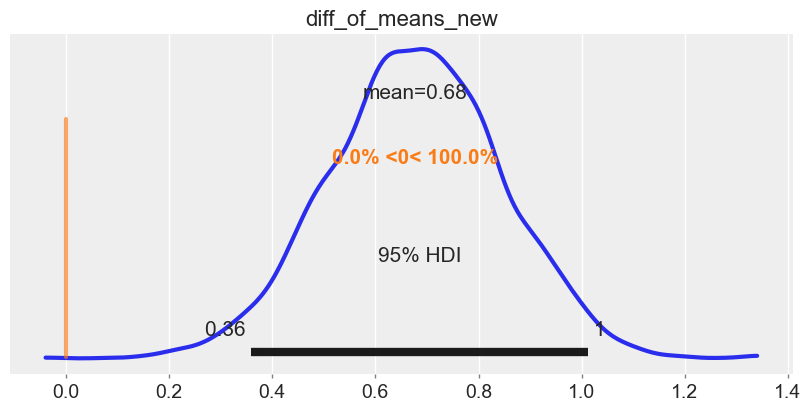

In [68]:
az.plot_posterior(trace_sensitivity,  var_names="diff_of_means_new", ref_val=0, hdi_prob=0.95)

<AxesSubplot: title={'center': 'diff_of_means_new'}>

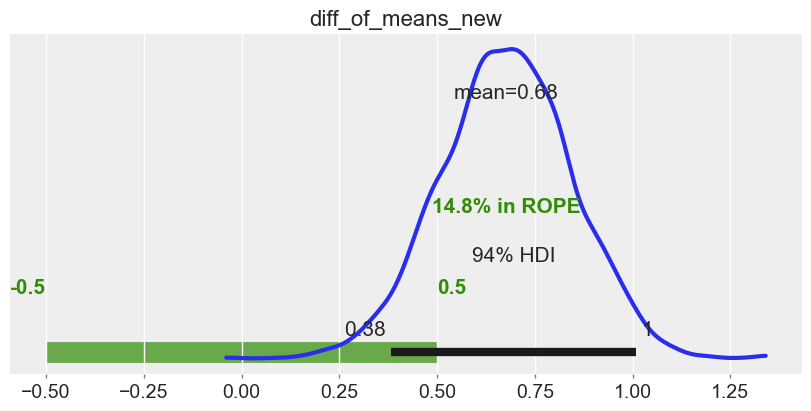

In [69]:
az.plot_posterior(trace_sensitivity,  var_names="diff_of_means_new", rope=[-0.5,0.5])

Given these results:

Evidence Points Towards Hypothesis: With 85% of the posterior distribution outside the ROPE, there's reasonably strong evidence suggesting a practically significant difference between the goals scored at home vs. away.

However, Not Completely Conclusive: The 15% in the ROPE means there's still some uncertainty.

# hyp 2


In [70]:
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase,home_goals,away_goals
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season,1,3
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season,3,6
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season,4,2
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season,5,2
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Do,29.04.2021,20:00,ZSC Lions,Genève-Servette HC,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",50,"SRF,RTS,RSI,MYSPORTS",20211105000354,NL,CH,Playoff 1/2 Final,1,4
2446,Sa,01.05.2021,20:00,SC Rapperswil-Jona Lakers,EV Zug,3:6,0:3|2:1|1:2,NaN,Ende,False,"St.Galler Kantonalbank Arena, 8640 Rapperswil SG",50,"SRF,RTS,RSI,MYSPORTS",20211105000355,NL,CH,Playoff 1/2 Final,3,6
2447,Mo,03.05.2021,20:00,EV Zug,Genève-Servette HC,1:0,0:0|1:0|0:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",50,"SRF,RTS,RSI,MYSPORTS",20211105000359,NL,CH,Playoff Final,1,0
2448,Mi,05.05.2021,19:00,Genève-Servette HC,EV Zug,1:2,0:0|1:1|0:1,NaN,Ende,False,"Les Vernets, 1227 Les Acacias GE",50,"SRF,RTS,RSI,MYSPORTS",20211105000360,NL,CH,Playoff Final,1,2


In [71]:
df.Resultat = df.Resultat.apply(lambda x: x.split(':')[0].strip() + ':' + x.split(':')[1].strip())

In [72]:
df.Resultat.unique()

array(['1:3', '3:6', '4:2', '5:2', '2:0', '3:2', '3:1', '1:4', '1:2',
       '3:4', '6:2', '4:6', '4:5', '5:4', '2:7', '4:3', '8:1', '5:3',
       '2:1', '3:5', '4:0', '3:0', '5:1', '2:6', '0:3', '6:0', '2:5',
       '2:3', '1:0', '4:1', '6:3', '4:10', '0:1', '1:5', '2:4', '9:3',
       '0:5', '7:5', '0:2', '6:5', '8:0', '6:1', '4:8', '8:2', '1:6',
       '5:6', '7:0', '6:4', '8:7', '5:0', '3:7', '0:4', '7:3', '11:0',
       '4:7', '8:4', '7:2', '1:9', '7:1', '0:6', '7:4', '0:7', '9:4',
       '1:8', '8:3', '1:7', '9:2', '10:3', '8:5', '6:9', '5:7', '7:6',
       '6:7', '4:9', '3:9', '3:8'], dtype=object)

In [73]:
df.drop(df[df.Resultat == '0:0'].index, inplace=True)

In [74]:
df.head()

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase,home_goals,away_goals
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season,1,3
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season,3,6
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season,4,2
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season,5,2
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season,2,0


In [75]:
home_stadiums = {df.Home.unique()[i]: df.Stadion.unique()[i] for i in range(len(df.Home.unique()))}

In [76]:
home_stadiums

{'HC Ajoie': 'Raiffeisen Arena, 2900 Porrentruy JU',
 'SC Bern': 'PostFinance-Arena, 3014 Bern BE',
 'ZSC Lions': 'Hallenstadion, 8050 Zürich ZH',
 'EV Zug': 'BOSSARD Arena, 6303 Zug',
 'HC Lugano': 'Cornèr Arena, 6948 Porza Ti',
 'EHC Biel-Bienne': 'Tissot Arena, 2504 Biel/Bienne BE',
 'Fribourg-Gottéron': 'BCF Arena, 1700 Fribourg FR',
 'HC Ambri-Piotta': 'Gottardo Arena, 6775 Ambri TI',
 'HC Davos': 'Eisstadion Davos, 7270 Davos-Platz GR',
 'SC Rapperswil-Jona Lakers': 'St.Galler Kantonalbank Arena, 8640 Rapperswil SG',
 'SCL Tigers': 'Ilfishalle, 3550 Langnau im Emmental BE',
 'Genève-Servette HC': 'Les Vernets, 1227 Les Acacias GE',
 'Lausanne HC': 'Vaudoise Aréna, 1008 Lausanne VD',
 'EHC Kloten': 'Hallenstadion AG, Zürich',
 'SC Langenthal': 'PostFinance-Arena, Bern'}

In [77]:
df[df.Home =='HC Ajoie'].Stadion.unique()

array(['Raiffeisen Arena, 2900 Porrentruy JU'], dtype=object)

In [78]:
home_stadion = {team: df[df.Home == team].Stadion.unique()[-1] for team in df.Home.unique()}

home_stadion

{'HC Ajoie': 'Raiffeisen Arena, 2900 Porrentruy JU',
 'SC Bern': 'PostFinance-Arena, Bern',
 'ZSC Lions': 'Hallenstadion AG, Zürich',
 'EV Zug': 'BOSSARD Arena, Zug',
 'HC Lugano': 'Piste Resega, 6948 Porza Ti',
 'EHC Biel-Bienne': 'Tissot Arena 1, Biel-Bienne',
 'Fribourg-Gottéron': 'BCF Arena, Fribourg',
 'HC Ambri-Piotta': 'Stadio Valascia, 6775 Ambri TI',
 'HC Davos': 'Vaillant Arena, 7270 Davos-Platz GR',
 'SC Rapperswil-Jona Lakers': 'St.Galler Kantonalbank Arena, 8640 Rapperswil SG',
 'SCL Tigers': 'Stade de Suisse, 3000 Bern BE',
 'Genève-Servette HC': 'Les Vernets, Genève',
 'Lausanne HC': 'Centre Sportif Malley, 1008 Lausanne VD',
 'EHC Kloten': 'SWISS Arena, 8302 Kloten ZH',
 'SC Langenthal': 'KEB Schoren, 4900 Langenthal BE'}